In [1]:
import xgboost, textblob, string

#import data_helpers
#from DataProcessor import DataProcessor
import data_utility as du
import numpy as np

import pandas as pd 
import nltk
import seaborn as sns
import string
import warnings 
import csv
import scipy
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.stem.porter import *
#from keras.preprocessing import text, sequence
from keras import preprocessing
from keras import layers, models, optimizers
from gensim.models import word2vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from scipy.sparse import hstack
import mglearn
from __future__ import  print_function
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier
from operator import itemgetter
import pyLDAvis
import pyLDAvis.sklearn
%pylab
%matplotlib inline

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/christophersmyth/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#  Detecting Sarcasm in Twitter



# Introduction

Sarcasm is a mode of communication where the meaning of a statement is the opposite of what is said.  Detecting sarcasm in written text could help determine the true intent or sentiment of individuals towards issues, products or services.

In verbal communication the presence of sarcasm can be conveyed through facial expressions and tone.  While these tools are not available for written text, other modes of expression such as emoji, elongated text and repeated text are.  The model explored these, other twitter specific forms of expression (hashtags and mentions) as well as sentiment.


# Summary

Preparation:
- Multiple applications and dictionaries had to be built in order to normalize twitter text due to extensive use of slang and acronyms

General Data Exploration:
- Most tweets did not utilize emoji, or hashtags
- Most tweets had at least one Mention (18 tweets had 50 mentions)
- LDA analysis did reveal interpretable topics among the tweets
- Sarcastic vs Non-Sarcastic Data Comparison:
- Very little difference in the most used words
- Very few words specific to sarcastic or non-sarcastic tweets
- Top non-sarcastic hashtags were pop culture related
- Both utilized the “face with tears of joy” emoji but sarcastic tweets utilized more of them
- When elongated words were used, both used mainly just 1 elongated word and both did it about as often
- Sarcastic tweets had more repeated text/emoji/punctuation counts
- Sarcastic tweets used hashtags almost three times more than non-sarcastic tweets
- Tweets that used an extreme number of hashtags (i.e more than 10) were almost all sarcastic
- Sarcastic tweets used slightly more mentions than non-sarcastic tweets
- Tweets that used an extreme number of mentions where mostly non-sarcastic
- Most tweets were positive with sarcastic tweets being slightly more positive and no-sarcastic tweets being slightly more negative 
- When sentiment of noun phrase, verb phrase and the entire tweet were compared, most tweets did not have a contradiction in sentiment, however if there was a contradiction, sarcastic tweets contained slightly more sentiment contradictions than non-sarcastic

Features:
- Bag of Emoji
- Repeated and Elongated word count
- Mention and Hashtag counts
- Detailed Sentiment of full tweet, verb phrases and noun phrases
- Contradiction flag: noted any contradiction between tweet, verb phrase and noun phrase
- Word level tf-idf 

Most Important Features:
- Hashtag Count
- Tweet Neutral Sentiment Score
- Mention Count
- Noun Phrase Sentiment Score
- Full Tweet Sentiment Score


Best Models:
- Vanilla Logistic Regression
- Ridge Regression
- Lasso Regression
- Extreme Gradient Boost
- Support Vector Machine

Conclusion:

It was unexpected that the sarcastic and non-sarcastic tweets had so many similar characteristics.  Given the nature of sarcasm I expected there to be more contradictions in sentiment between the tweet and the tweets verb phrases and noun phrases.  If sentiment was going to be a factor, I expected it would have been the positive or negative sentiment that would have been the most influential.  Instead it was the neutral sentiment scores that proved to be the most important features.

Improvements:
- Larger dataset
- Loose antonyms
- Interjection detection



# Getting Tweets

A separate application has been built to get the data from twitter utilizing the twitter api.  The application utilized the #sarcasm hashtag to identify sarcastic tweets.

## Pull from Twitter

In [2]:
raw_uncurated  = pd.read_csv('even_sarc_5710_20181022_1524.csv')
#train.columns = ['id', 'label', 'orig']

In [3]:
raw_uncurated.head()

,id,label,tweets
0,0.0,1.0,@mitchellreports @ChuckGrassley @SenKamalaHarr...
1,0.0,1.0,@paintingcorner You mean average followed by h...
2,0.0,1.0,@elizabethforma Probably should start handing ...
3,0.0,1.0,@SenBlumenthal In Roman times a loss like this...
4,0.0,1.0,I love #sarcasm just short of passive aggressi...


In [4]:
raw_uncurated.shape

(5710, 3)

In [5]:
raw = raw_uncurated.copy()

# Baseline

In [6]:
raw[raw['label']==1]['label'].count()/raw['label'].count()

0.5

# Text Cleaning

## Remove Sarcasm Related Tags

In [7]:
no_sarcasm_tags = pd.DataFrame()
no_sarcasm_tags = raw.copy()

In [8]:
du.word_count_sarc_nonsarc_list(find_word_list=['#sarcasm','#sarcastic'],
                           text=no_sarcasm_tags['tweets'],
                          label=no_sarcasm_tags['label'])

#sarcasm
label 1 = 2880
label 0 = 0
#sarcastic
label 1 = 16
label 0 = 0


In [9]:
no_sarcasm_tags['tweets'] = du.remove_word_from_list('#sarcasm', no_sarcasm_tags['tweets'])
no_sarcasm_tags['tweets'] = du.remove_word_from_list('#sarcastic', no_sarcasm_tags['tweets'])

In [10]:
du.word_count_sarc_nonsarc_list(find_word_list=['#sarcasm','#sarcastic'],
                           text=no_sarcasm_tags['tweets'],
                          label=no_sarcasm_tags['label'])

#sarcasm
label 1 = 0
label 0 = 0
#sarcastic
label 1 = 0
label 0 = 0


## Dictionary for Object Standardization

An application was created to scrape acronyms and slang from netlingo.com and create a dictionary that could be used to translate acronyms and slang used in tweets.

In [11]:
acronyms_jargon_translate = {}
with open('acronyms_20181018_1624.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        acronyms_jargon_translate[row[0]] = row[1]

## Word Normalization

### Expand Contractions

A dictionary of contractions was created to expand contractions.

In [12]:
clean_tracking = pd.DataFrame()
clean_tracking['label'] = no_sarcasm_tags['label']
clean_tracking['original'] = no_sarcasm_tags['tweets']

In [13]:
clean_tracking['contractions_expanded'] = du.expand_contractions(clean_tracking['original'])

### Spell Check and Tag

Ekphrasis was used to spell check and tag elements on text (i.e. elongated words, repeated words, etc)

In [14]:
clean_tracking['text_processor'] = clean_tracking['contractions_expanded']

In [15]:
more_acronyms_dict = {
    "the us": "the united states",
    " f ": "frick",
    " fu ": "frick you",
    " u ": "you"
}
tweet_processor = du.get_tweet_processor(additional_dictionary_list=[acronyms_jargon_translate, more_acronyms_dict])

1
3
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [16]:
# get the processed text and un tokenize 
clean_tracking['text_processor'] = clean_tracking['text_processor'].apply(tweet_processor.pre_process_doc)
clean_tracking['text_processor'] = clean_tracking['text_processor'].apply(' '.join)

### Remove Tags from Processed Text

Except for "sarcasm" and "sarcastic", all hashtags have been expanded and will be treated as words.

Email addresses, URLs, numbers related to phone numbers, time, dates, etc. will be removed.

In [17]:
clean_tracking['tags_removed'] = du.remove_tags_from_processed_text(clean_tracking['text_processor'])

### Remove Punctuation, Numbers and Special Characters

In [18]:
clean_tracking['remove_punc_num_spch'] = clean_tracking['tags_removed'].apply(du.clean_tweet)

### Remove Stop Words

In [19]:
stop_words = stopwords.words('english')
#low_value_words = ['like', 'would', 'get', 'know']
#drop_words = stop_words + low_value_words
drop_words = stop_words

pat = r'\b(?:{})\b'.format('|'.join(drop_words))
clean_tracking['remove_stop_words'] = clean_tracking['remove_punc_num_spch'].str.replace(pat, '')
clean_tracking['remove_stop_words'] = clean_tracking['remove_stop_words'].str.replace(r'\s+', ' ')


### Lemmatization

In [20]:
clean_tracking['lemmatized'] = du.lemmatize_list(clean_tracking['remove_stop_words'])

# Analyze Data

In [23]:
# isolate data for analysis section
analysis = pd.DataFrame()
analysis['text'] = clean_tracking['lemmatized']
analysis['label'] = clean_tracking['label']
analysis['orig'] = clean_tracking['original']

## Most Common Words in Tweets

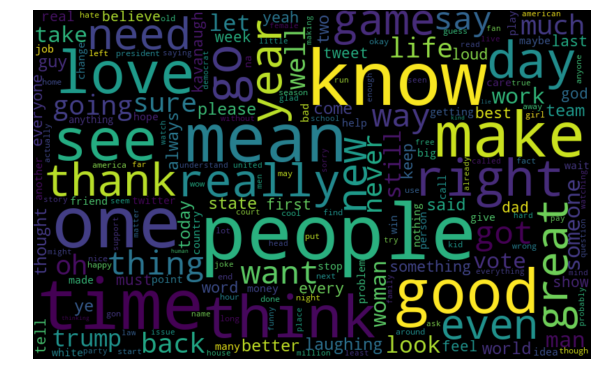

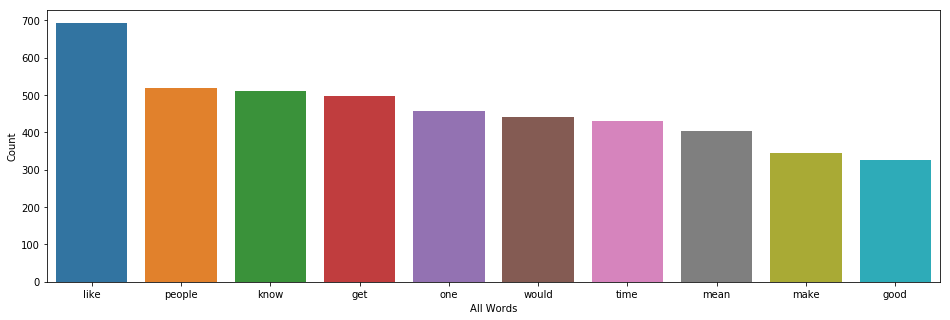

In [24]:
du.sentences_to_wordcloud(analysis['text'], drop_words)
wordcount_all = du.sentences_to_sortedwordcount(analysis['text'], drop_words)
du.wordcount_to_bar('All Words', 'Count', wordcount_all)

## Emoji Usage

Most tweets did no utilize emojis.

In [25]:
import importlib
import data_utility as du
importlib.reload(du)

<module 'data_utility' from '/Users/christophersmyth/sandbox/bootcamp/temp/bootcamp/cpTextClassifier/data_utility.py'>

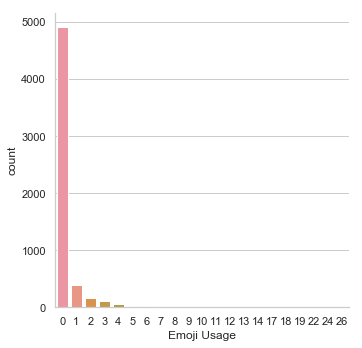

In [26]:
emoji_usage_count = du.get_emoji_usage_count(clean_tracking['original'])
du.counts_to_graph('Emoji Usage', emoji_usage_count)

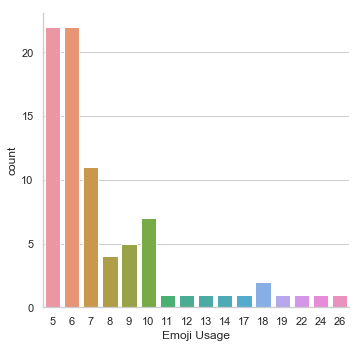

In [27]:
du.counts_to_graph_filter_low(4, 'Emoji Usage', emoji_usage_count)

In [28]:
du.get_tweets_based_on_count(26, raw['tweets'], emoji_usage_count).iloc[0]

"@MHFOfficial @MariaBrink 😂😂 i Only Smoke #Crack~#Cocaine😲😵☠💀&amp;💉Shoot💉#Heroin💀☠😲😵if it's High-Quality🏆&amp; pure🎀 😂 it's #Sarcasm @Twitter🐦-Police👮#Bots👾 Don't Block me for 7 days Again; Last time i #Email📧&amp;🐦#TwitterBot👾👮Didn't Believe i Was #Spoof/Mocking #Racist's👩#Tweet🐦)🚫#Racists✋"

## Emoji Used

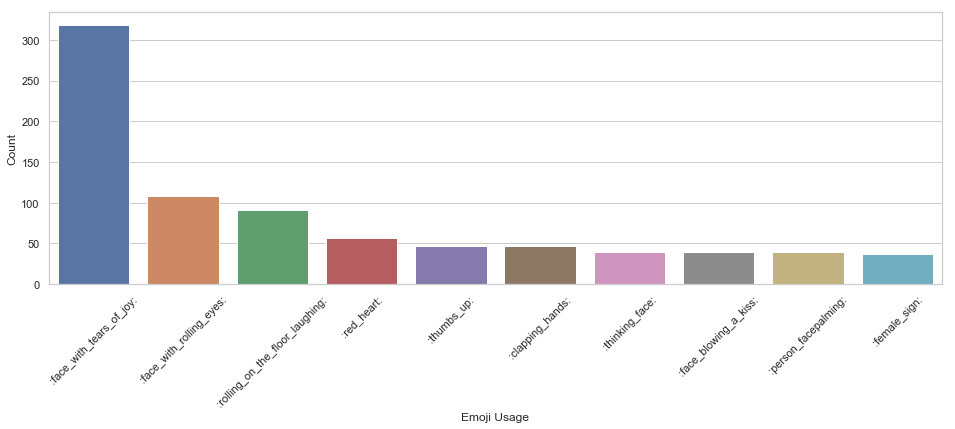

In [29]:
all_emoji = du.get_sorted_emoji_counts(clean_tracking['original'])
all_emoji_text = du.demojize_sorted_emoji_counts(all_emoji)
du.wordcount_to_bar('Emoji Usage', 'Count', all_emoji_text, rotate=True)

## Hashtag Usage

In [30]:
mention_hash_dict = du.get_hashtag_mention_counts(clean_tracking['original'])
hash_dict = pd.DataFrame

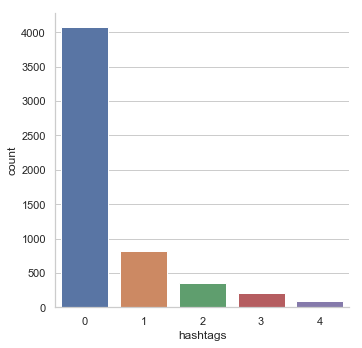

In [31]:
du.counts_to_graph_filter_high(5,'hashtags', mention_hash_dict['hashtags'])

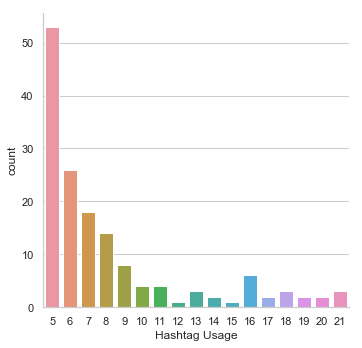

In [32]:
du.counts_to_graph_filter_low(4, 'Hashtag Usage', mention_hash_dict['hashtags'])

In [33]:
du.get_tweets_based_on_count(21, clean_tracking['original'], mention_hash_dict['hashtags']).iloc[0]

'Be a ProblemSolver !, not creator \n #problemSolving #design #creativity #designThinking #innovation #Win #CEO #HumanCenteredDesign #culture #entrepreneur #Funny #Businessdesign #Creative  #people #love #thankful #entrepreneur #startup #research #cleanEating #bengaluru'

## Hashtags Used

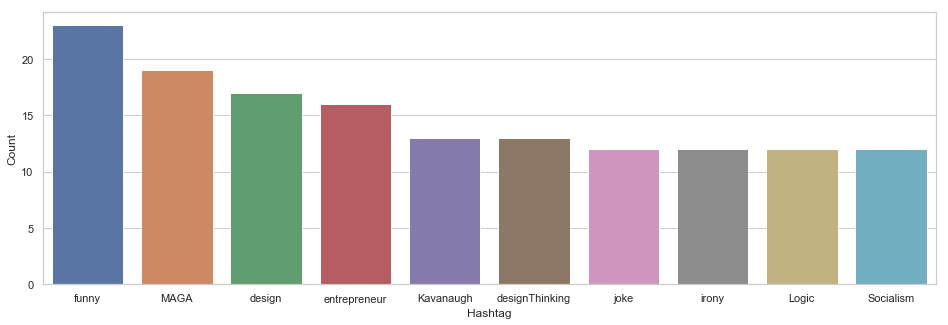

In [34]:
all_hashtags = du.sentences_to_sorted_hashtags(clean_tracking['original'], drop_words)
du.wordcount_to_bar('Hashtag','Count',all_hashtags)

## Mentions Usage

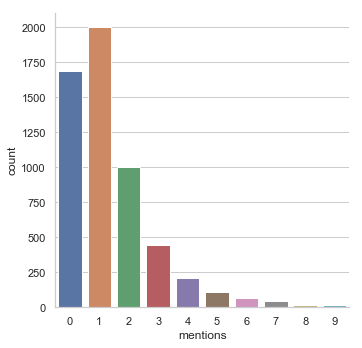

In [35]:
du.counts_to_graph_filter_high(10,'mentions', mention_hash_dict['mentions'])

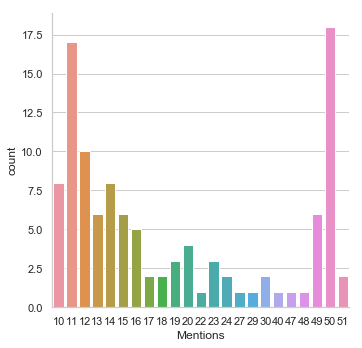

In [36]:
du.counts_to_graph_filter_low(9, 'Mentions', mention_hash_dict['mentions'])

In [37]:
du.get_tweets_based_on_count(50, clean_tracking['original'], mention_hash_dict['mentions']).iloc[0]

'@GadflyMorse @shipman96 @jackhammer3853 @sallyodum @tbw24431703 @katalin_pota @LiberalWarriors @4anniereilly @danintheoutback @Roger02235695 @melodijoy @jrphoenix77 @nevbav @Lynne__Andrea @PoliticalJudo @EddieMarine1 @WokeZilla95 @Jessiedoth @TodMoore3 @TomStark88 @RijuColonDee @LeftwardSwing @Ellahbie @briane2874 @thenewalliance2 @Heybabalou @studiohq @Quiggling @cdbrzezinski @bearingleft @cathyxOR @earlerichardsjr @hayley561girl @dgendvil @KenJones707 @hiya_jazz @ConsiderThis1 @PaulDeCristofo4 @jesseawayne1 @Sea_Stories @keptitmoving @aarrrgggghhhhh3 @BarbaraLNewsome @Montgomery_bjm @ILikeRainWater @OldWhiteManLfty @superhotgrammy @LucyTreadwell01 @pdq8ball @gjnmedia I cant believe Russia is responsible for this. Repeat my words, Russia, Russia, Russia, Susan Sarandon. Now that we can agree that HRC and Obama saved us from Russia, lets congratulate HRC on the Amazon 15$ wage. '

## Visualizing Word Vectors

In [38]:
for_word2vec = pd.DataFrame()
for_word2vec['text'] = clean_tracking['lemmatized']
for_word2vec['label'] = clean_tracking['label']

In [39]:
corpus = du.build_corpus(for_word2vec)

In [40]:
model = word2vec.Word2Vec(corpus, size=100, window=60, min_count=80, workers=4)

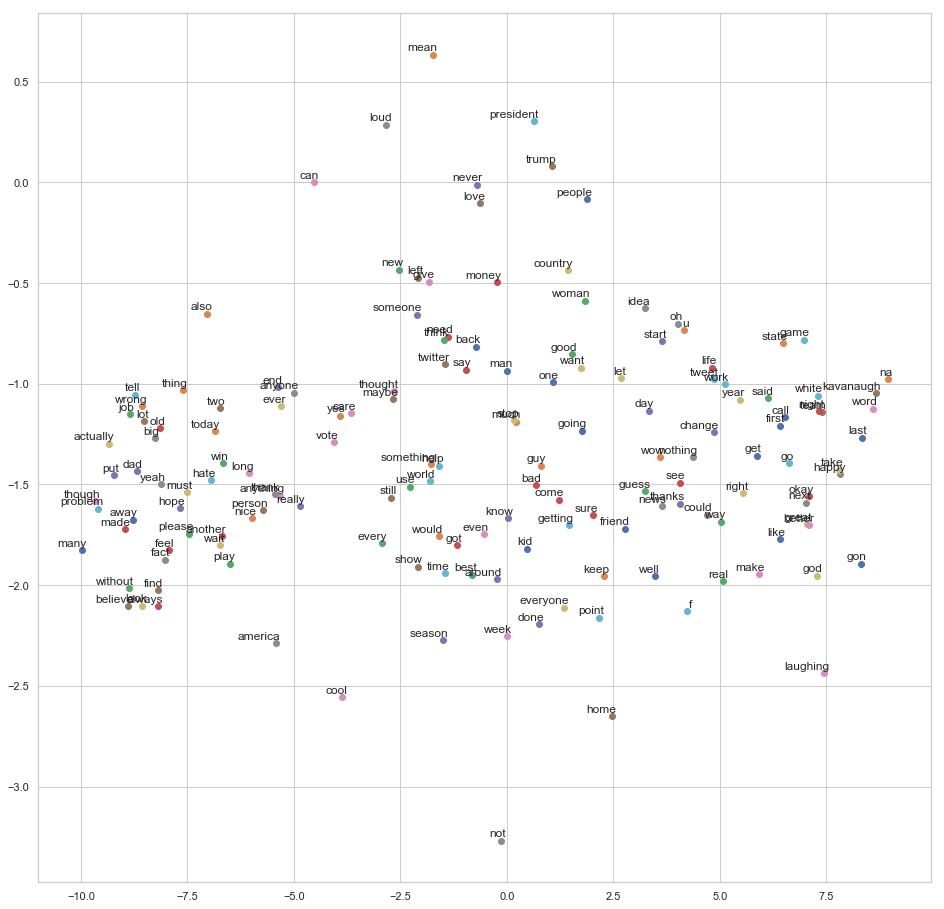

In [41]:
du.tsne_plot(model)

## Topic Modelling

In [42]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
dtm=vect.fit_transform(for_word2vec['text'])
lda=LatentDirichletAllocation(n_components=3)
lda.fit_transform(dtm)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


array([[0.96290503, 0.01903423, 0.01806073],
       [0.04986613, 0.05381431, 0.89631956],
       [0.02972993, 0.93959975, 0.03067031],
       ...,
       [0.95533099, 0.02302015, 0.02164886],
       [0.41940009, 0.3200982 , 0.2605017 ],
       [0.68842706, 0.13118728, 0.18038566]])

In [43]:
lda_dtf=lda.fit_transform(dtm)
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(3), feature_names=features,
sorting=sorting, topics_per_chunk=3, n_words=10)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


topic 0       topic 1       topic 2       
--------      --------      --------      
like          like          people        
time          time          like          
mean          mean          day           
want          way           trump         
laughing      know          know          
said          people        thanks        
word          life          love          
know          say           come          
loud          state         think         
game          make          good          




In [44]:
pyLDAvis.enable_notebook()
zit=pyLDAvis.sklearn.prepare(lda,dtm,vect)
pyLDAvis.display(zit)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Sarcasm Analysis

## Word Count

### Non-Sarcastic Word Count

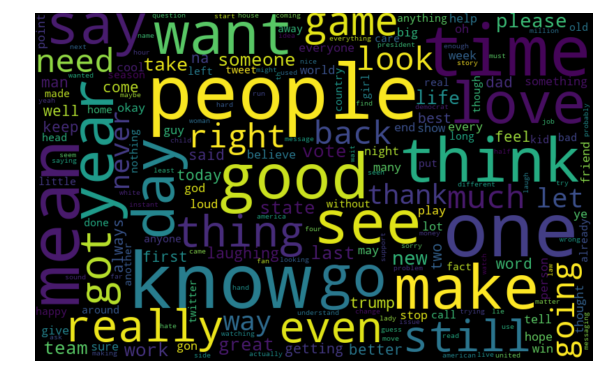

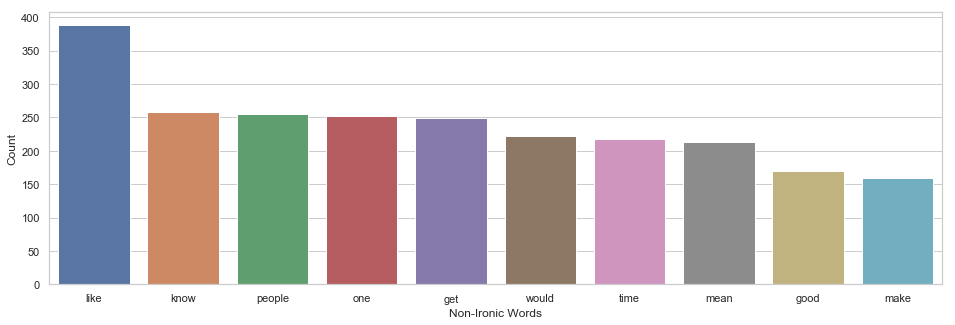

In [45]:
du.sentences_to_wordcloud(analysis['text'][analysis['label']==0], drop_words)
wordcount_nonironic = du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==0], drop_words)
du.wordcount_to_bar('Non-Ironic Words', 'Count', wordcount_nonironic)

### Sarcastic Word Count

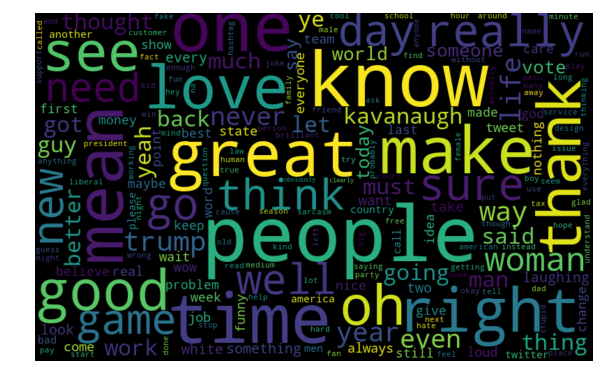

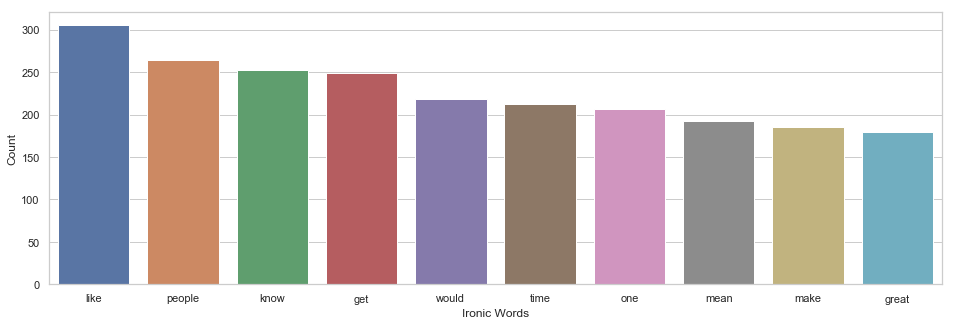

In [46]:
du.sentences_to_wordcloud(analysis['text'][analysis['label']==1], drop_words)
wordcount_ironic = du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==1], drop_words)
du.wordcount_to_bar('Ironic Words', 'Count', wordcount_ironic)

### Unique Non-Sarcastic Words

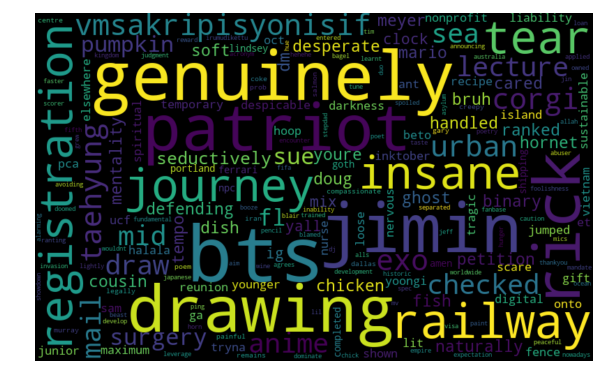

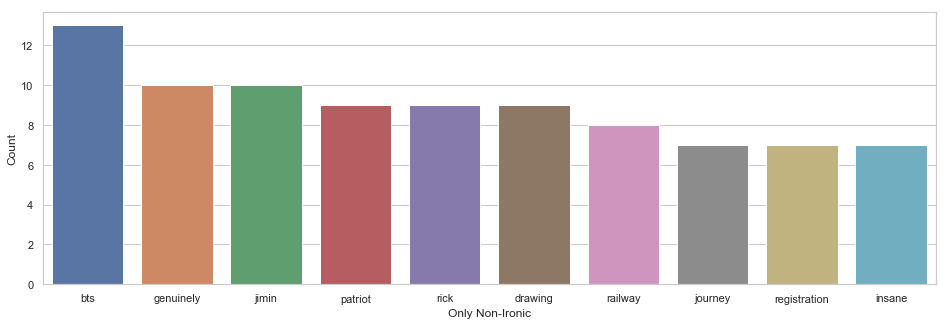

In [47]:
ironic_words = du.sentences_to_words(analysis['text'][analysis['label']==1]).split()
nonironic_words = du.sentences_to_words(analysis['text'][analysis['label']==0]).split()
du.sentences_to_wordcloud(analysis['text'][analysis['label']==0], drop_words+ironic_words) 
wordcount_only_nonironic = du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==0], drop_words+ironic_words) 
du.wordcount_to_bar('Only Non-Ironic', 'Count', wordcount_only_nonironic)

### Unique Sarcastic Words

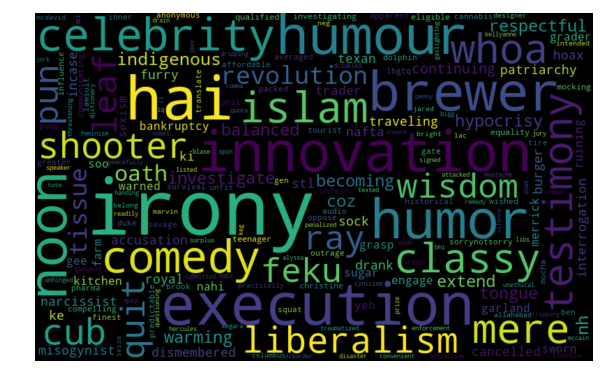

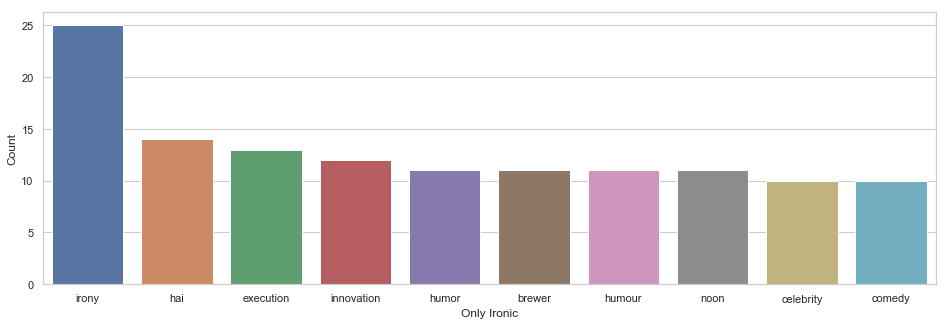

In [48]:
du.sentences_to_wordcloud(analysis['text'][analysis['label']==1], drop_words+nonironic_words) 
wordcount_only_ironic=du.sentences_to_sortedwordcount(analysis['text'][analysis['label']==1], drop_words+nonironic_words)[:10] 
du.wordcount_to_bar('Only Ironic', 'Count', wordcount_only_ironic)

## Hashtags

### Non-Ironic Hashtags

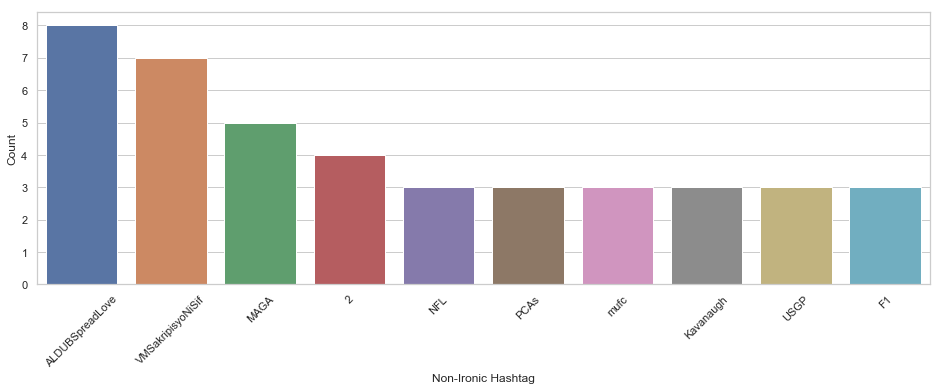

In [49]:
nonironic_hashtags = du.sentences_to_sorted_hashtags(analysis['orig'][analysis['label']==0], drop_words)
du.wordcount_to_bar('Non-Ironic Hashtag','Count',nonironic_hashtags, rotate=True)

### Ironic Hashtags

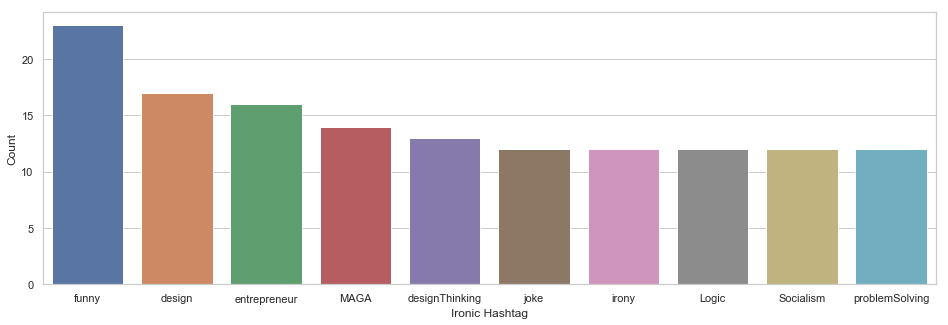

In [50]:
ironic_hashtags = du.sentences_to_sorted_hashtags(analysis['orig'][analysis['label']==1], drop_words)
du.wordcount_to_bar('Ironic Hashtag','Count',ironic_hashtags)

## Emoji

### Nonsarcastic Emoji

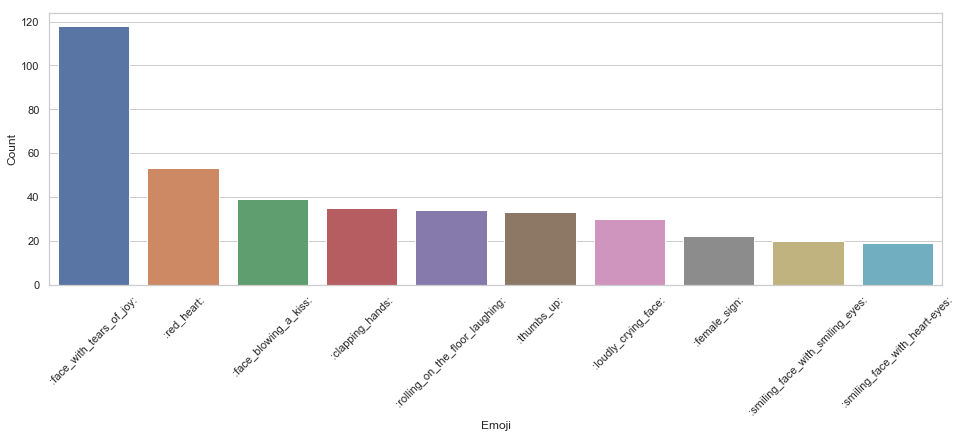

In [51]:
nonsarc_emjoi = du.get_sorted_emoji_counts(clean_tracking[clean_tracking['label']==0]['original'])
nonsarc_emjoi_text = du.demojize_sorted_emoji_counts(nonsarc_emjoi)
du.wordcount_to_bar('Emoji', 'Count', nonsarc_emjoi_text, rotate=True)

### Sarcastic Emoji

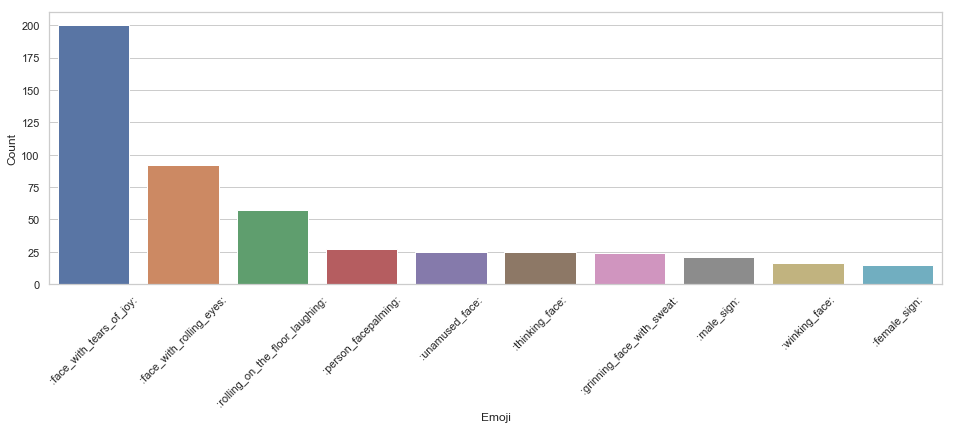

In [52]:
sarc_emjoi = du.get_sorted_emoji_counts(clean_tracking[clean_tracking['label']==1]['original'])
sarc_emjoi_text = du.demojize_sorted_emoji_counts(sarc_emjoi)
du.wordcount_to_bar('Emoji', 'Count', sarc_emjoi_text, rotate=True)

### Elongated and Repeated Words

In [53]:
# change the text to label
rep_elong = du.get_elongated_repeated_from_tags(clean_tracking['text_processor'])

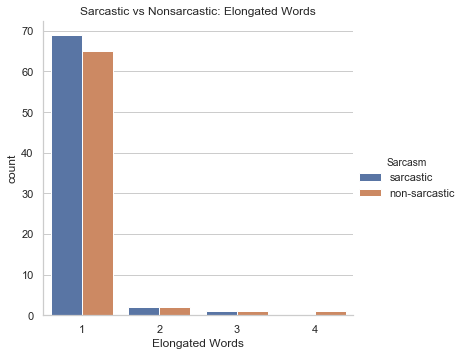

In [54]:
du.sarc_vs_non_graph_limit('Elongated Words', 
                        rep_elong['elongated'], 
                        clean_tracking['label'],0)

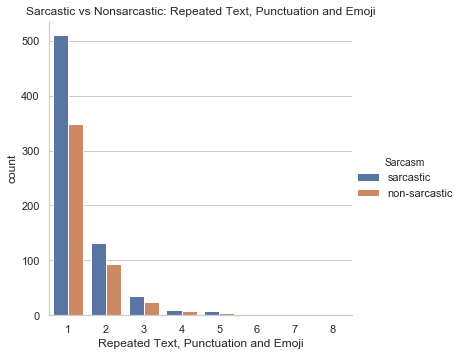

In [55]:
du.sarc_vs_non_graph_limit('Repeated Text, Punctuation and Emoji', 
                        rep_elong['repeated'], 
                        clean_tracking['label'],
                        0)

## Hashtag Usage

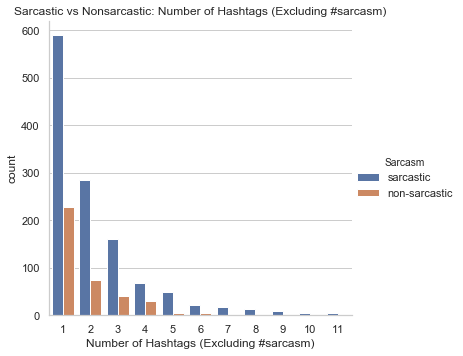

In [56]:
du.sarc_vs_non_graph_limit('Number of Hashtags (Excluding #sarcasm)', 
                        mention_hash_dict['hashtags'], 
                        clean_tracking['label'],
                        0,12)

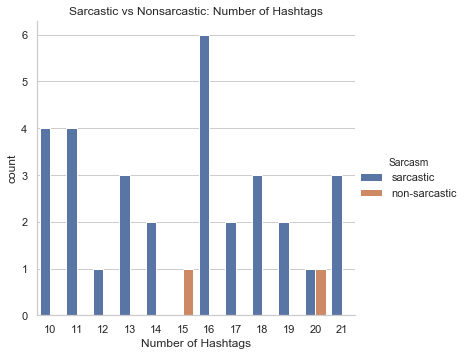

In [57]:
du.sarc_vs_non_graph_limit('Number of Hashtags', 
                        mention_hash_dict['hashtags'], 
                        clean_tracking['label'],
                        9)

## Mentions 

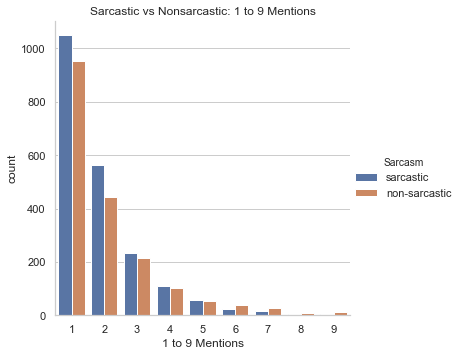

In [58]:
du.sarc_vs_non_graph_limit('1 to 9 Mentions', 
                        mention_hash_dict['mentions'], 
                        clean_tracking['label'],
                        0,10)

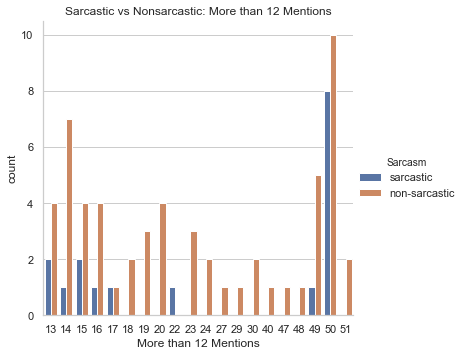

In [59]:
du.sarc_vs_non_graph_limit('More than 12 Mentions', 
                        mention_hash_dict['mentions'], 
                        clean_tracking['label'],
                        12)

## Sentiment

### General Sentiment 

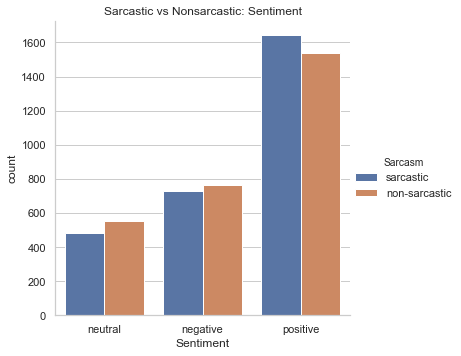

In [60]:
sentiment_data_list = du.get_sentiment_textblob(clean_tracking['lemmatized'])
du.sarc_vs_non_graph('Sentiment', sentiment_data_list, clean_tracking['label'])

### Sentiment Intensity

In [61]:
sentiment_feats = pd.DataFrame()
sentiment_feats = du.generate_sentiment_feats(clean_tracking['lemmatized'])
sentiment_feats.head()

,t_neg,t_pos,t_neu,t_cmpd,vp_neg,vp_pos,vp_neu,vp_cmpd,n_neg,n_pos,n_neu,n_cmpd
0,0.000,0.156,0.844,0.4019,0.0,0.583,4.417,0.1027,0.000,0.000,6.000,0.0000
1,0.000,0.289,0.711,0.4310,0.0,0.000,2.000,0.0000,0.000,0.000,1.000,0.0000
2,0.216,0.246,0.539,0.1280,0.0,0.000,3.000,0.0000,0.000,0.000,3.000,0.0000
3,0.332,0.440,0.228,0.3182,0.0,1.000,1.000,0.4939,1.479,1.218,1.303,-0.6880
4,0.172,0.521,0.307,0.6908,0.0,1.000,2.000,0.6369,1.000,0.000,2.000,-0.4215


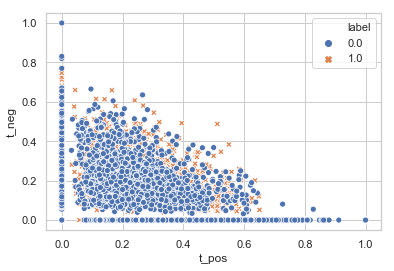

In [62]:
scatter = pd.DataFrame()
scatter = sentiment_feats
scatter['label'] = clean_tracking['label']
ax = sns.scatterplot(x="t_pos", y="t_neg",hue="label", style="label", data=scatter)

In [63]:
graphs = [['t_cmpd', 'Full Tweet Compound Sentiment'],
         ['t_pos', 'Full Tweet Positive Sentiment'],
         ['t_neg','Full Tweet Negative Sentiment'],
         ['vp_cmpd','Verb Phrase Compound Sentiment'],
         ['vp_pos','Verb Phrase Positive Sentiment'],
         ['vp_neg','Verb Phrase Negative Sentiment'],
         ['n_cmpd','Noun Phrase Compound Sentiment'],
         ['n_pos','Noun Phrase Positive Sentiment'],
         ['n_neg','Noun Phrase Negative Sentiment']]

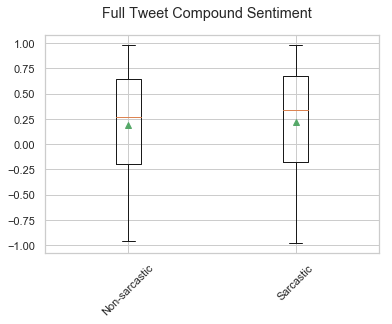

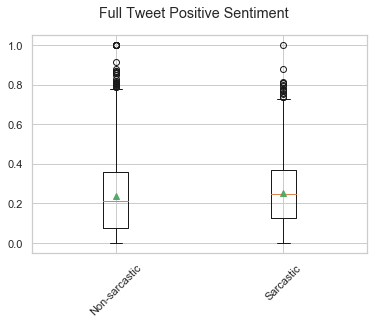

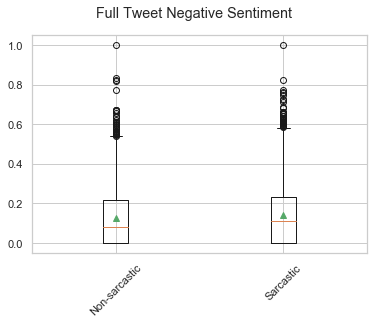

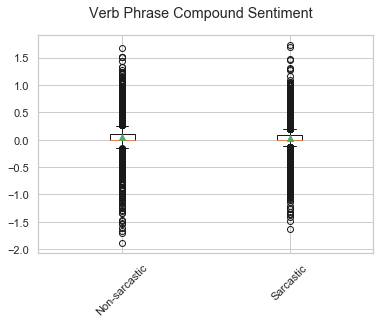

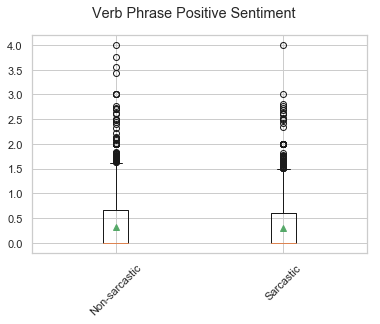

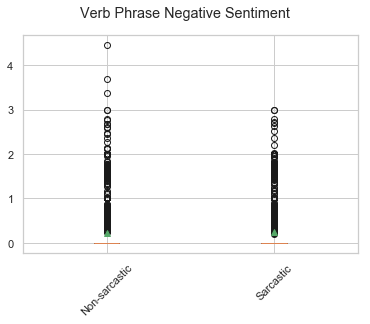

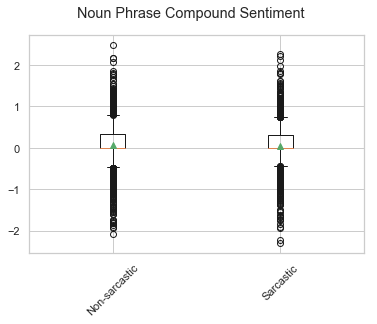

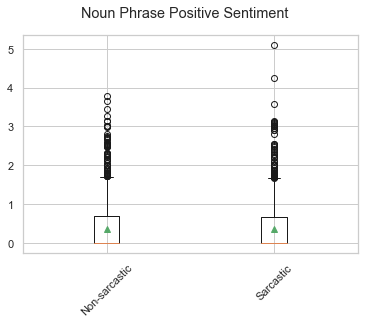

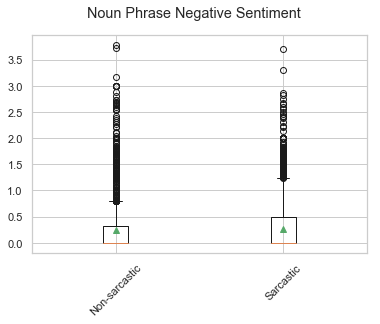

In [64]:
for graph in graphs:
    du.sentiment_intensity_box_compare(graph[1],graph[0],sentiment_feats, clean_tracking['label'])

### Sentiment Contradictions

In [65]:
#identify contradictions in sentiment
contradiction = []
for index, r in sentiment_feats.iterrows():
    if r['t_cmpd'] > 0 and r['vp_cmpd'] < 0:
        contradiction.append(1)
    elif r['t_cmpd'] < 0 and r['vp_cmpd'] > 0:
        contradiction.append(1)
    elif r['n_cmpd'] > 0 and r['vp_cmpd'] < 0:
        contradiction.append(1)
    elif r['n_cmpd'] < 0 and r['vp_cmpd'] > 0:
        contradiction.append(1)
    elif r['t_cmpd'] < 0 and r['n_cmpd'] > 0:
        contradiction.append(1)
    elif r['t_cmpd'] > 0 and r['n_cmpd'] < 0:
        contradiction.append(1)
    else:
        contradiction.append(0)

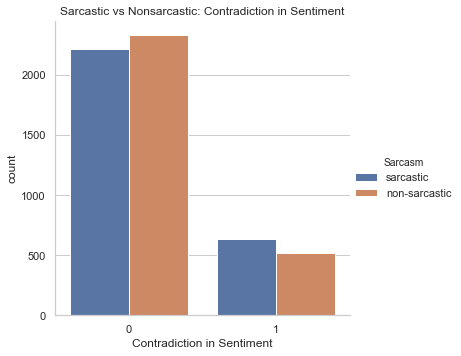

In [66]:
du.sarc_vs_non_graph('Contradiction in Sentiment', contradiction, clean_tracking['label'])

# Features

## Bag of Emoji

In [67]:
bag_of_emoji_feats = pd.DataFrame()
bag_of_emoji_feats = du.get_bag_of_emoji(clean_tracking['original'])

In [68]:
bag_of_emoji_feats.head()

,:face_with_tears_of_joy:,:face_with_rolling_eyes:,:rolling_on_the_floor_laughing:,:red_heart:,:thumbs_up:,:clapping_hands:,:thinking_face:,:face_blowing_a_kiss:,:person_facepalming:,:female_sign:,...,:two_hearts:,:winking_face_with_tongue:,:smirking_face:,:squinting_face_with_tongue:,:purple_heart:,:sparkling_heart:,:beer_mug:,:expressionless_face:,:slightly_smiling_face:,:pouting_face:
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Repeated and Elongated 

In [69]:
# change the text to label
rep_elong_feats = pd.DataFrame()
rep_elong_feats['repeated'] = rep_elong['repeated']
rep_elong_feats['elongated'] = rep_elong['elongated']
rep_elong_feats.head()

,repeated,elongated
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0


## Mention and Hashtag

In [70]:
ment_tag_feats = pd.DataFrame()
ment_tag_feats['mentions'] = mention_hash_dict['mentions']
ment_tag_feats['hashtags'] = mention_hash_dict['hashtags']
ment_tag_feats.head()

,mentions,hashtags
0,5,0
1,1,0
2,1,2
3,1,0
4,0,0


## Sentiment

In [71]:
sentiment_cont_feats = pd.DataFrame()
sentiment_cont_feats = sentiment_feats.drop('label',axis=1)
sentiment_cont_feats['contradiction'] = contradiction
sentiment_cont_feats.head()

,t_neg,t_pos,t_neu,t_cmpd,vp_neg,vp_pos,vp_neu,vp_cmpd,n_neg,n_pos,n_neu,n_cmpd,contradiction
0,0.000,0.156,0.844,0.4019,0.0,0.583,4.417,0.1027,0.000,0.000,6.000,0.0000,0
1,0.000,0.289,0.711,0.4310,0.0,0.000,2.000,0.0000,0.000,0.000,1.000,0.0000,0
2,0.216,0.246,0.539,0.1280,0.0,0.000,3.000,0.0000,0.000,0.000,3.000,0.0000,0
3,0.332,0.440,0.228,0.3182,0.0,1.000,1.000,0.4939,1.479,1.218,1.303,-0.6880,1
4,0.172,0.521,0.307,0.6908,0.0,1.000,2.000,0.6369,1.000,0.000,2.000,-0.4215,1


## Feature Importance

In [72]:
nontfidf_feats = pd.DataFrame()
nontfidf_feats = pd.concat([sentiment_cont_feats,
                   ment_tag_feats,
                   rep_elong_feats,
                   bag_of_emoji_feats], axis=1)

In [73]:
y=clean_tracking['label']

In [74]:
# feature extraction
model = ExtraTreesClassifier()
model.fit(nontfidf_feats, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [75]:
cols_vals = []
for index, col in enumerate(nontfidf_feats.columns):
    cols_vals.append([col,model.feature_importances_[index]])
sorted(cols_vals, key=itemgetter(1), reverse=True)[:20]   

[['hashtags', 0.1128764771178952],
 ['t_neu', 0.09245405166243022],
 ['mentions', 0.08720415507462227],
 ['n_neu', 0.08657365678961414],
 ['t_cmpd', 0.08643494511364933],
 ['t_pos', 0.08002372380945741],
 ['vp_neu', 0.07394321413786795],
 ['n_cmpd', 0.053776787231681056],
 ['t_neg', 0.05304185423696538],
 ['vp_cmpd', 0.04462355363003014],
 ['n_pos', 0.04214431897852604],
 ['vp_pos', 0.033140027131509736],
 ['repeated', 0.031940627091574775],
 ['n_neg', 0.0303077749053752],
 ['vp_neg', 0.026983959808979885],
 [':face_with_tears_of_joy:', 0.008465678022959637],
 ['elongated', 0.007566104639383328],
 ['contradiction', 0.0060446653024417655],
 [':face_with_rolling_eyes:', 0.005396202524841879],
 [':rolling_on_the_floor_laughing:', 0.003554968501239626]]

## TF-IDF Features

In [76]:
# isolate data for tf-idf feature creation
x_train_tfidf = clean_tracking['lemmatized']

### Word Level

In [77]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50000)
tfidf_vect.fit(x_train_tfidf)
xtrain_tfidf =  tfidf_vect.transform(x_train_tfidf)

### ngram Level  

In [78]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=50000)
tfidf_vect_ngram.fit(x_train_tfidf)
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(x_train_tfidf)

### Character Level 

In [79]:
# character level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=50000)
tfidf_vect_ngram_chars.fit(x_train_tfidf)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train_tfidf)

# Models

In [80]:
y=clean_tracking['label']

In [81]:
nontfidf_feats.shape

(5710, 50)

In [82]:
xtrain_tfidf.shape

(5710, 13507)

In [83]:
# combine features
all_features = scipy.sparse.hstack([xtrain_tfidf,nontfidf_feats]).toarray()

## Linear Classifier

In [84]:
lc_tfidf_word = du.Model('LC Word TF-IDF',xtrain_tfidf,y,linear_model.LogisticRegression())
lc_tfidf_ngram = du.Model('LC N-Gram',xtrain_tfidf_ngram,y,linear_model.LogisticRegression())
lc_ftidf_ngram_chars = du.Model('LC Char TF-IDF',xtrain_tfidf_ngram_chars,y,linear_model.LogisticRegression())
lc_nontfidf = du.Model('LC Non TF-IDF',nontfidf_feats,y,linear_model.LogisticRegression())
lc_all_features = du.Model('LC All Features',all_features,y,linear_model.LogisticRegression())

,Name,CV Mean,CV Range,Time
0,LC Word TF-IDF,0.623117,0.038529,0.062490
1,LC N-Gram,0.572855,0.026270,0.019812
2,LC Char TF-IDF,0.612609,0.022767,0.109753
3,LC Non TF-IDF,0.654991,0.052539,0.032818
4,LC All Features,0.702277,0.028897,0.837039


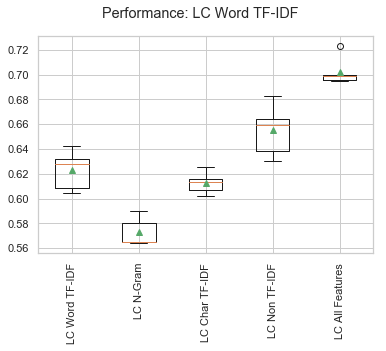

In [85]:
lc_tfidf_word.fullCompareList([lc_tfidf_ngram,lc_ftidf_ngram_chars,lc_nontfidf,lc_all_features])

### Lasso Regression

In [86]:
lassoParams = {'C':np.linspace(.1,4,25),
              'penalty':('l1',)}
gslsr = GridSearchCV(linear_model.LogisticRegression(), 
                     lassoParams, 
                     return_train_score=True,
                    verbose=True)
gsOut = gslsr.fit(all_features,y)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.0min finished


best parameters: {'C': 1.2375, 'penalty': 'l1'}
best score:      0.69054 (+/-0.00932)


,mean_test_score,std_test_score,param_C,param_penalty
7,0.690543,0.009321,1.2375,l1
8,0.688441,0.009466,1.4,l1
6,0.688091,0.009606,1.075,l1
10,0.686690,0.008667,1.725,l1
5,0.686515,0.016215,0.9125,l1
9,0.686340,0.007295,1.5625,l1
4,0.684764,0.017675,0.75,l1
11,0.684063,0.005157,1.8875,l1
3,0.681611,0.015744,0.5875,l1
12,0.678809,0.005289,2.05,l1


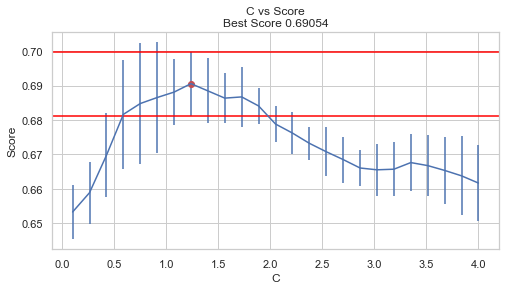

In [87]:
du.GridSearchTablePlot(gslsr,"C", negative=False)

In [88]:
lassoRegModelParams = {'C': 1.2375,
               'penalty': 'l1'}
ls_all_features = du.Model('Lasso All Features',all_features,y,linear_model.LogisticRegression(),**lassoRegModelParams)

Model:		Lasso All Features
CV Mean:	0.6945709281961471
CV Range:	0.03677758318739055
Train Time:	0.509162187576294
CV Scores: 
[0.71891419 0.69176883 0.68914186 0.69089317 0.6821366 ]


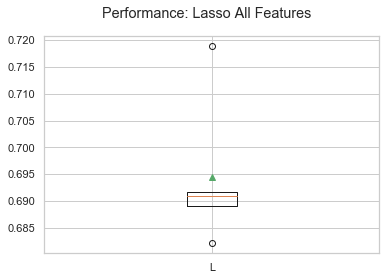

In [89]:
ls_all_features.performance()

### Ridge

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.0min finished


best parameters: {'C': 1.2, 'penalty': 'l2'}
best score:      0.69054 (+/-0.00604)


,mean_test_score,std_test_score,param_C,param_penalty
5,0.690543,0.006043,1.2,l2
6,0.689492,0.003242,1.4,l2
4,0.688967,0.006234,1,l2
3,0.687916,0.008098,0.8,l2
1,0.686865,0.012167,0.4,l2
2,0.686865,0.012046,0.6,l2
7,0.686515,0.002241,1.6,l2
8,0.684939,0.002495,1.8,l2
10,0.684413,0.004706,2.2,l2
9,0.684413,0.002924,2,l2


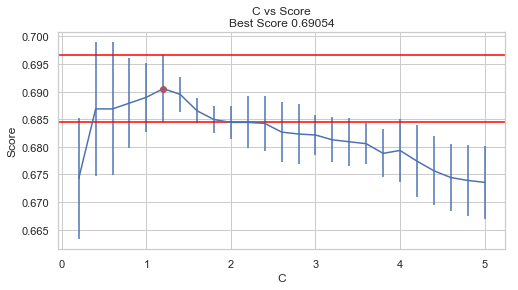

In [90]:
ridgeParams = {'C':np.linspace(.2,5,25),
              'penalty':('l2',)}
lrlrd = GridSearchCV(linear_model.LogisticRegression(), 
                     ridgeParams, 
                     return_train_score=True, 
                     verbose=True)
gslrd = lrlrd.fit(all_features,y)
du.GridSearchTablePlot(gslrd,"C", negative=False)

In [91]:
ridgeRegModelParams = {'C': 1.2,
               'penalty': 'l2'}
rd_all_features = du.Model('Ridge All Features',all_features,y,linear_model.LogisticRegression(),**ridgeRegModelParams)

Model:		Ridge All Features
CV Mean:	0.7008756567425569
CV Range:	0.021015761821366108
Train Time:	0.44671106338500977
CV Scores: 
[0.71628722 0.69702277 0.69702277 0.69877408 0.69527145]


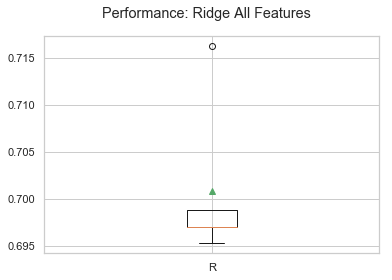

In [92]:
rd_all_features.performance()

### Logistic Regression Model Comparison

,Name,CV Mean,CV Range,Time
0,LC All Features,0.702277,0.028897,0.837039
1,Lasso All Features,0.694571,0.036778,0.509162
2,Ridge All Features,0.700876,0.021016,0.446711


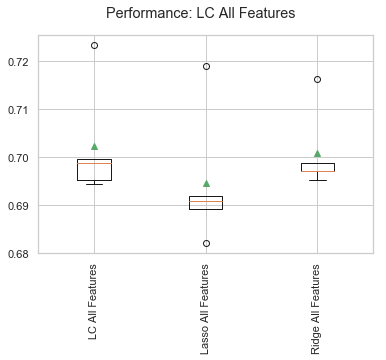

In [93]:
lc_all_features.fullCompareList([ls_all_features, rd_all_features])

## SVM

In [94]:
svm_tfidf_word = du.Model('SVM Word TF-IDF',xtrain_tfidf,y,svm.LinearSVC())
svm_allnontfidf = du.Model('SVM Non-TF-IDF',nontfidf_feats,y,svm.LinearSVC())
svm_all_features = du.Model('SVM All Features',all_features,y,svm.LinearSVC())

,Name,CV Mean,CV Range,Time
0,SVM Word TF-IDF,0.614711,0.030648,0.080414
1,SVM Non-TF-IDF,0.652715,0.058669,0.411898
2,SVM All Features,0.670753,0.026270,0.899360


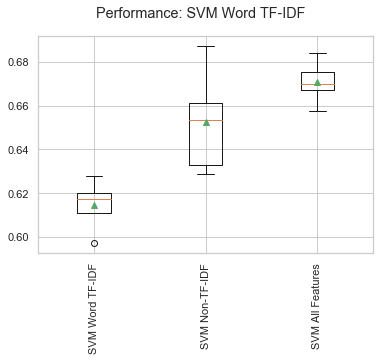

In [95]:
svm_tfidf_word.fullCompareList([svm_allnontfidf,svm_all_features])

In [96]:

svcParams = {'C':range(1,6)}
svcgs = GridSearchCV(svm.LinearSVC(), 
                     svcParams, 
                     return_train_score=True, 
                     n_jobs=4,
                    verbose=True)
svcgs.fit(all_features,y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   45.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4, param_grid={'C': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

best parameters: {'C': 1}
best score:      0.66340 (+/-0.00440)


,mean_test_score,std_test_score,param_C
0,0.663398,0.004399,1
1,0.654991,0.001492,2
2,0.651839,0.002146,3
3,0.650788,0.003368,4
4,0.649037,0.002321,5


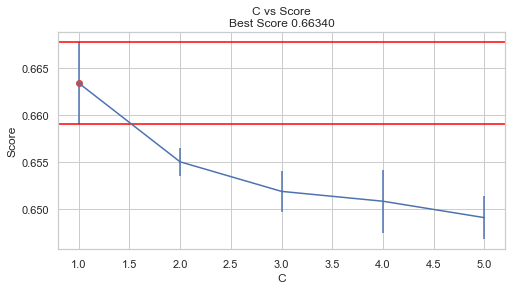

In [97]:
du.GridSearchTablePlot(svcgs,"C", negative=False)

## Extreme Gradient Boosting

In [99]:
xgb_tfidf_word = du.Model('Word TF-IDF',xtrain_tfidf,y,xgboost.XGBClassifier())
xgb_allnontfidf = du.Model('Non-TF-IDF',nontfidf_feats,y,xgboost.XGBClassifier())
xgb_all_features = du.Model('XGB All Features',all_features,y,xgboost.XGBClassifier())

,Name,CV Mean,CV Range,Time
0,Word TF-IDF,0.603678,0.037653,1.461535
1,Non-TF-IDF,0.674781,0.040280,0.903630
2,XGB All Features,0.686165,0.049037,211.230654


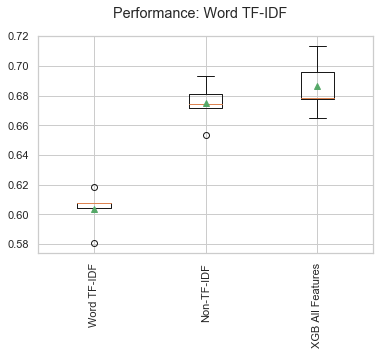

In [100]:
xgb_tfidf_word.fullCompareList([xgb_allnontfidf, xgb_all_features])

# Model Comparison

,Name,CV Mean,CV Range,Time
0,XGB All Features,0.686165,0.049037,211.230654
1,SVM All Features,0.670753,0.026270,0.899360
2,Lasso All Features,0.694571,0.036778,0.509162
3,LC All Features,0.702277,0.028897,0.837039
4,Ridge All Features,0.700876,0.021016,0.446711


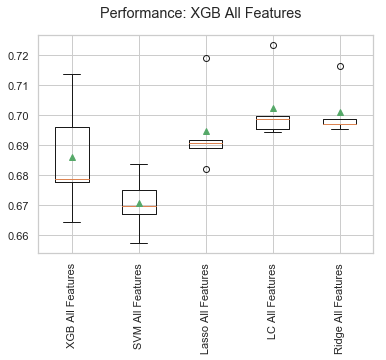

In [103]:
xgb_all_features.fullCompareList([svm_all_features,ls_all_features, lc_all_features,rd_all_features])